In [1]:
%load_ext autoreload
%autoreload 2
%pdb
%matplotlib inline

Automatic pdb calling has been turned ON


In [2]:
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18})
from collections import defaultdict, OrderedDict

from utils.generic import init_params
from main.seir.optimiser import Optimiser
from models.seir.seir_testing import SEIR_Testing
from data.processing import get_district_time_series
from data.dataloader import get_covid19india_api_data

## Load covid19 data

In [3]:
dataframes = get_covid19india_api_data()

In [4]:
dataframes.keys()

dict_keys(['df_tested', 'df_statewise', 'df_india_time_series', 'df_districtwise', 'df_raw_data', 'df_raw_data_2', 'df_travel_history', 'df_resources'])

In [5]:
df_district = get_district_time_series(dataframes)

In [6]:
df_district

,date,total_infected
0,2020-03-09,1
1,2020-03-10,4
2,2020-03-11,4
3,2020-03-12,5
4,2020-03-13,5
5,2020-03-14,5
6,2020-03-15,5
7,2020-03-16,5
8,2020-03-17,8
9,2020-03-18,11


In [7]:
## TODO: Make splits
df_train = df_district

## Loss Calculation Functions

In [8]:
def _calc_rmse(y_pred, y_true, log=True):
    if log:
        y_true = np.log(y_true)
        y_pred = np.log(y_pred)
    loss = np.sqrt(np.mean((y_true - y_pred)**2))
    return loss

def _calc_mape(y_pred, y_true):
    y_pred = y_pred[y_true > 0]
    y_true = y_true[y_true > 0]

    ape = np.abs((y_true - y_pred + 0) / y_true) *  100
    loss = np.mean(ape)
    return loss

def calc_loss_dict(states_time_matrix, df, method='rmse', rmse_log=False):
    pred_hospitalisations = states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
    pred_recoveries = states_time_matrix[9]
    pred_fatalities = states_time_matrix[10]
    pred_infectious_unknown = states_time_matrix[2] + states_time_matrix[4]
    pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities
    
    if method == 'rmse':
        if rmse_log:
            calculate = lambda x, y : _calc_rmse(x, y)
        else:
            calculate = lambda x, y : _calc_rmse(x, y, log=False)
    
    if method == 'mape':
            calculate = lambda x, y : _calc_mape(x, y)
    
    losses = {}
#     losses['hospitalised'] = calculate(pred_hospitalisations, df['Hospitalised'])
#     losses['recovered'] = calculate(pred_recoveries, df['Recovered'])
#     losses['fatalities'] = calculate(pred_fatalities, df['Fatalities'])
#     losses['active_infections'] = calculate(pred_infectious_unknown, df['Active Infections (Unknown)'])
    losses['total'] = calculate(pred_total_cases, df['total_infected'])
    
    return losses

def calc_loss(states_time_matrix, df, method='rmse', rmse_log=False):
    losses = calc_loss_dict(states_time_matrix, df, method, rmse_log)
#     loss = losses['hospitalised'] + losses['recovered'] + losses['total'] + losses['active_infections']
    loss = losses['total']
    return loss

## Initialize params and state values

In [9]:
vanilla_params, testing_params, state_init_values = init_params()

In [10]:
vanilla_params

{'R0': 2.2,
 'T_trans': 1.3181818181818181,
 'T_inc': 5.2,
 'T_inf': 2.9,
 'T_recov_mild': 11.1,
 'T_recov_severe': 28.6,
 'T_hosp': 5,
 'T_death': 32,
 'P_mild': 0.78,
 'P_severe': 0.2,
 'P_fatal': 0.02,
 'intervention_day': 100,
 'lockdown_removal_day': 45,
 'intervention_amount': 0.33,
 'N': 7000000.0}

In [11]:
state_init_values

OrderedDict([('S', 0.9999998571428571),
             ('E', 0),
             ('I', 1.4285714285714285e-07),
             ('D_E', 0),
             ('D_I', 0),
             ('R_mild', 0),
             ('R_severe_home', 0),
             ('R_severe_hosp', 0),
             ('R_fatal', 0),
             ('C', 0),
             ('D', 0)])

## Set priors for parameters of interest

In [12]:
## assuming uniform priors, following dictionary contains the ranges
prior_ranges = OrderedDict()
prior_ranges['R0'] = (1.6, 3)
prior_ranges['T_inc'] = (4, 5)
prior_ranges['T_inf'] = (3, 4)
prior_ranges['T_recov_severe'] = (9, 20)
prior_ranges['P_severe'] = (0.3, 0.99)
prior_ranges['intervention_amount'] = (0.3, 1)

def param_init():
    theta = defaultdict()
    for key in prior_ranges:
        theta[key] = np.random.uniform(prior_ranges[key][0], prior_ranges[key][1])
        
    return theta

## Proposal function to sample theta_new given theta_old

In [13]:
## stddevs for all params are set to 1/4 of the prior range length.
proposal_sigmas = OrderedDict()
for key in prior_ranges:
    proposal_sigmas[key] = 0.25 * (prior_ranges[key][1] - prior_ranges[key][0])

def proposal(theta_old):
    theta_new = np.random.normal(loc=[*theta_old.values()], scale=[*proposal_sigmas.values()])
    return dict(zip(theta_old.keys(), theta_new))

## Log Likelihood and Prior

In [14]:
def log_likelihood(theta):
    if (np.array([*theta.values()]) < 0).any():
        return -np.inf
    alpha = 0.01
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(df_train)
    df_prediction = optimiser.solve(theta, default_params, df_train)
    pred = np.array(df_prediction['total_infected'])
    true = np.array(df_train['total_infected'])
    sigma = alpha * true.std()
    N = len(true)
    ll = - (N * np.log(np.sqrt(2*np.pi) * sigma)) - (np.sum(((true - pred) ** 2) / (2 * sigma ** 2)))
    return ll

def log_prior(theta):
    prior = 1
    for key in prior_ranges:
        if in_valid_range(key, theta[key]):
            prior *= 1 / (prior_ranges[key][1] - prior_ranges[key][0])
        else:
            prior = 0
            break
    
    return np.log(prior)

def in_valid_range(key, value):
    return (value <= prior_ranges[key][1]) and (value >= prior_ranges[key][0])

## Acceptance function

In [15]:
def accept(theta_old, theta_new):    
    x_new = log_likelihood(theta_new) + log_prior(theta_new)
    x_old = log_likelihood(theta_old) + log_prior(theta_old)
    
    if (x_new) > (x_old):
        return True
    else:
        x = np.random.uniform(0, 1)
        return (x < np.exp(x_new - x_old))

## Metropolis loop

In [16]:
def metropolis(iter=10000):
    theta = param_init()
    accepted = [theta]
    rejected = list()
    
    for i in tqdm(range(iter)):
        theta_new = proposal(theta)
        if accept(theta, theta_new):
            theta = theta_new
        else:
            rejected.append(theta_new)
        accepted.append(theta)
    
    return accepted, rejected

In [17]:
acc, rej = metropolis()

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-14-b7d73cf55198>:24: RuntimeWarning: divide by zero encountered in log
  return np.log(prior)
100%|██████████| 10000/10000 [06:32<00:00, 25.45it/s]


In [18]:
samples = pd.DataFrame(acc)

In [19]:
samples

,R0,T_inc,T_inf,T_recov_severe,P_severe,intervention_amount
0,1.808120,4.467625,3.970796,17.432676,0.965034,0.611796
1,1.808120,4.467625,3.970796,17.432676,0.965034,0.611796
2,1.808120,4.467625,3.970796,17.432676,0.965034,0.611796
3,1.808120,4.467625,3.970796,17.432676,0.965034,0.611796
4,1.808120,4.467625,3.970796,17.432676,0.965034,0.611796
...,...,...,...,...,...,...
9996,2.962495,4.229112,3.240480,14.549629,0.956535,0.334549
9997,2.962495,4.229112,3.240480,14.549629,0.956535,0.334549
9998,2.962495,4.229112,3.240480,14.549629,0.956535,0.334549
9999,2.962495,4.229112,3.240480,14.549629,0.956535,0.334549


Text(0.5, 1.0, 'Parameter samples obtained from MCMC')

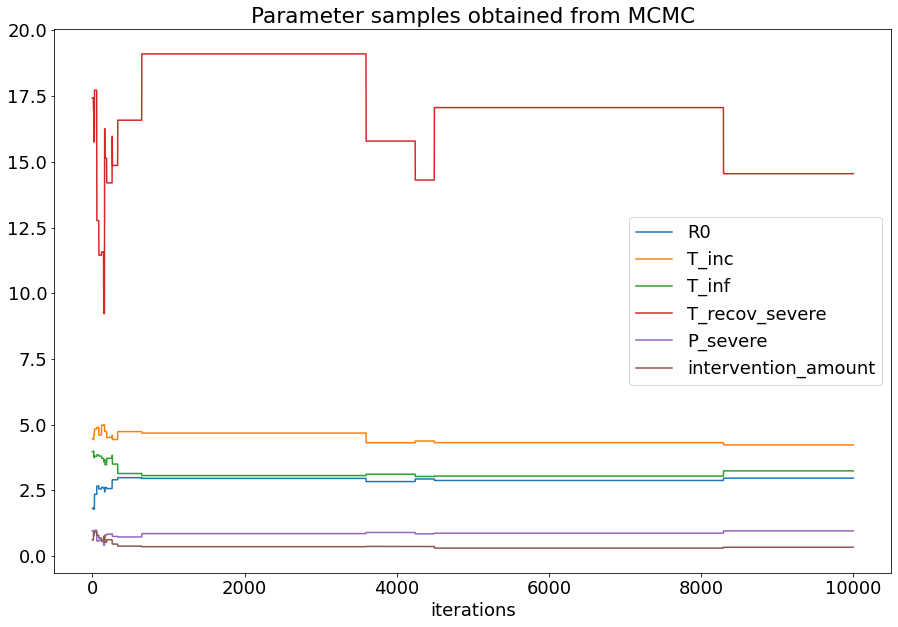

In [20]:
plt.figure(figsize=(15, 10))
for param in samples.columns:
    plt.plot(list(range(len(samples[param]))), samples[param], label=param)
plt.xlabel("iterations")
plt.legend()
plt.title("Parameter samples obtained from MCMC")

In [21]:
rej_samples = pd.DataFrame(rej)

Text(0.5, 1.0, 'Rejected Parameter samples obtained from MCMC')

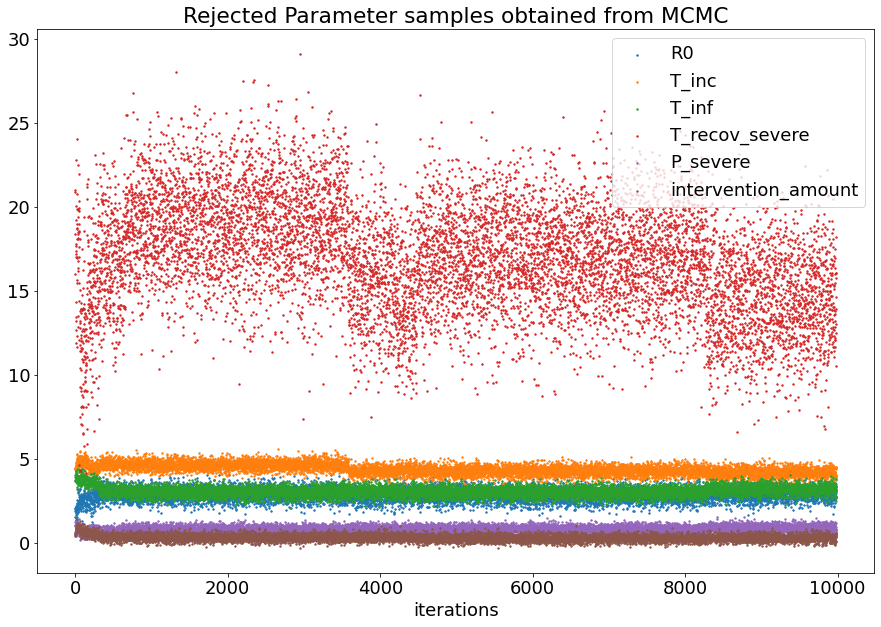

In [22]:
plt.figure(figsize=(15, 10))
for param in rej_samples.columns:
    plt.scatter(list(range(len(rej_samples[param]))), rej_samples[param], label=param, s=2)
plt.xlabel("iterations")
plt.legend()
plt.title("Rejected Parameter samples obtained from MCMC")